/var/folders/h5/n23g3h1s3rx_m3_gc9xtb8th0000gn/T/ipykernel_25239/535802033.py:113: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=filtered_stars_avg_rating.values, y=filtered_stars_avg_rating.index, palette="magma")


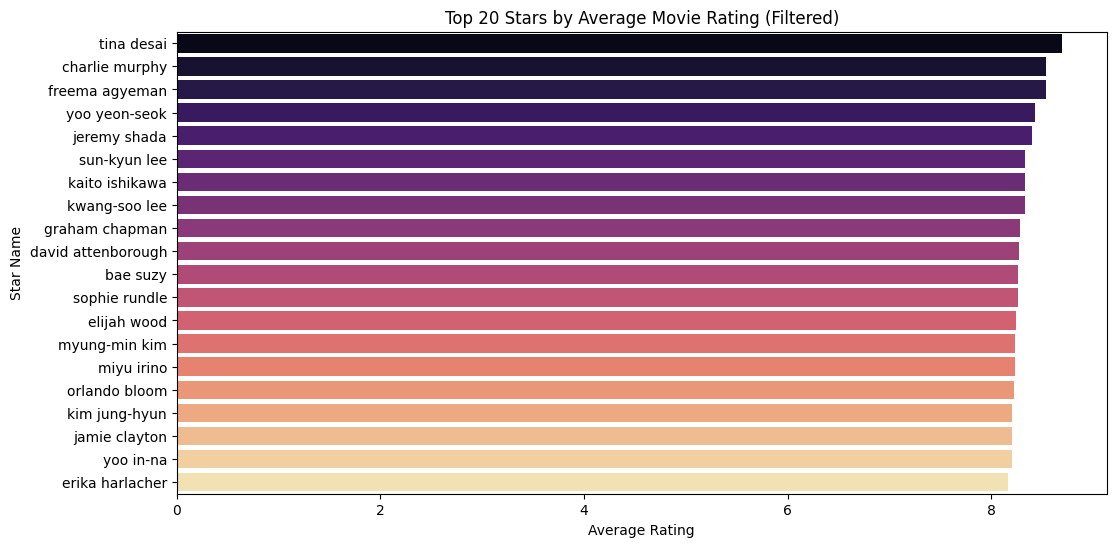

/var/folders/h5/n23g3h1s3rx_m3_gc9xtb8th0000gn/T/ipykernel_25239/535802033.py:129: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=filtered_directors_avg_rating.values, y=filtered_directors_avg_rating.index, palette="viridis")


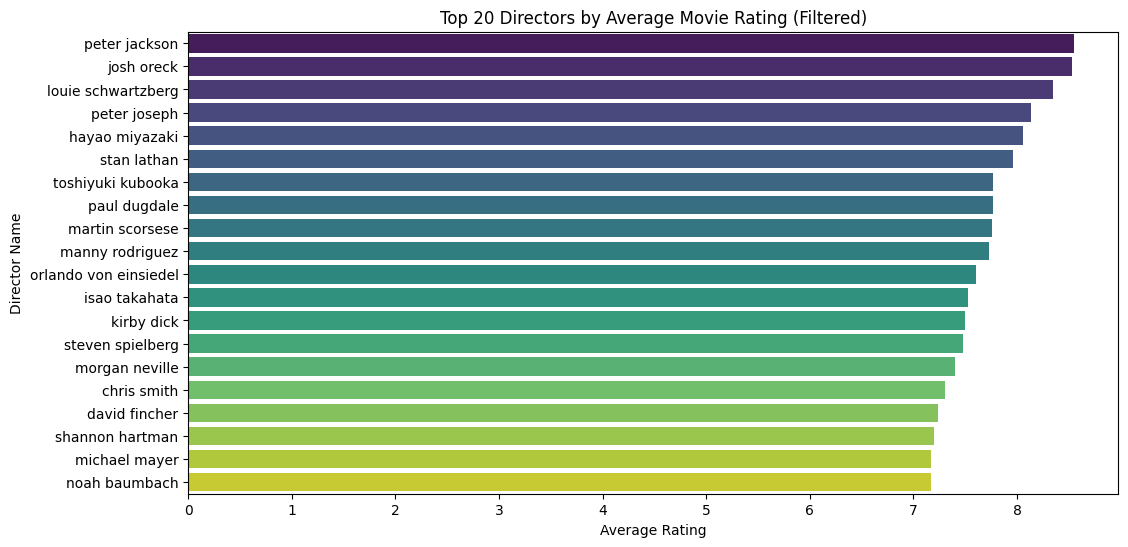

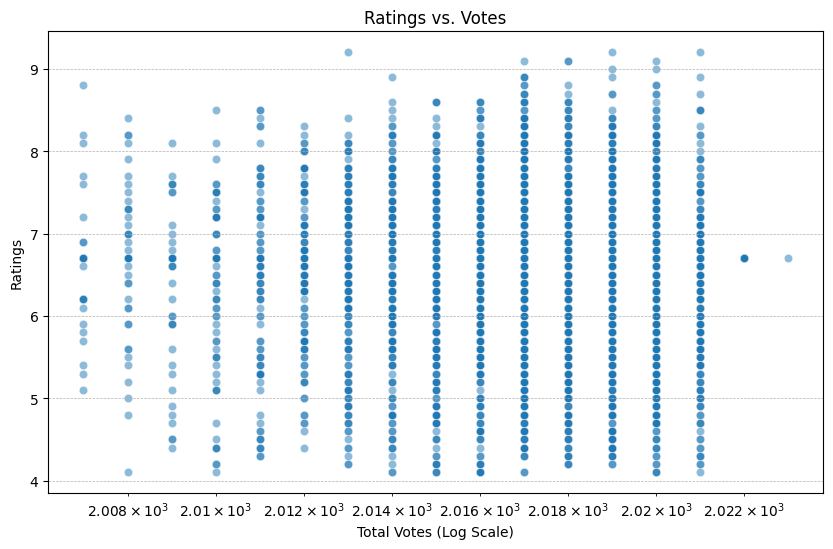

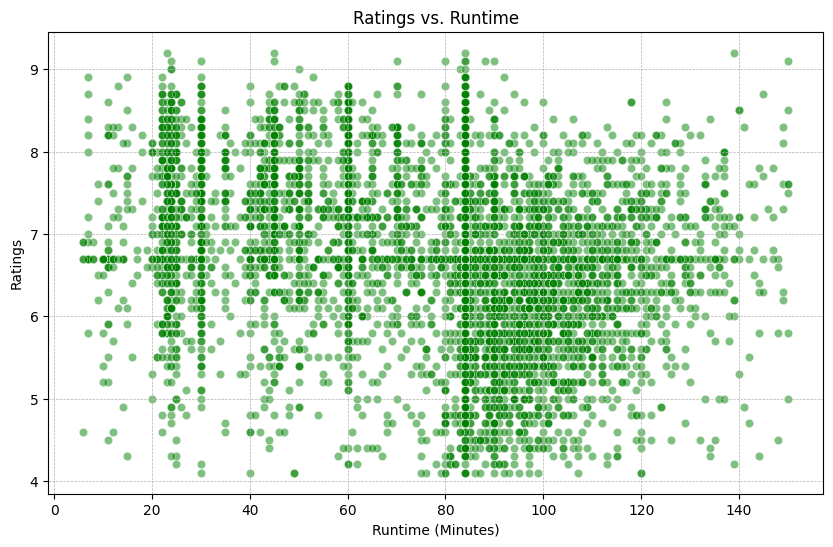

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from collections import Counter
from datetime import datetime
import numpy as np

# Load the dataset
movies = pd.read_csv("movies.csv")

# Convert column names to lowercase for consistency
movies.columns = movies.columns.str.lower()

# Standardize the 'movies' column (convert to lowercase, trim spaces, remove extra spaces)
movies['movies'] = movies['movies'].str.lower().str.replace(r'\s+', ' ', regex=True).str.strip()

# Remove duplicate movie entries based on the 'movies' column
movies.drop_duplicates(subset=['movies'], inplace=True)

# Handle missing values in 'genre' by replacing them with 'unknown'
movies.fillna({'genre': 'unknown'}, inplace=True)
movies['genre'] = movies['genre'].str.lower().str.replace(r'\s+', ' ', regex=True).str.strip()

# Clean 'one-line' descriptions (standardize text formatting)
movies['one-line'] = movies['one-line'].str.lower().str.replace(r'\s+', ' ', regex=True).str.strip()

# Ensure 'stars' column follows a standardized format
def add_missing_director(row):
    """ Ensures every entry in the 'stars' column includes both director and stars information. """
    if isinstance(row, str) and 'director:' in row.lower():
        if 'stars:' in row.lower():
            return row
        else:
            return row + (" stars: unknown" if '|' in row else "| stars: unknown")
    elif isinstance(row, str) and 'stars:' in row.lower():
        return "director: unknown| " + row
    else:
        return "director: unknown| stars: unknown"

movies['stars'] = movies['stars'].apply(add_missing_director)
movies['stars'] = movies['stars'].str.lower().str.replace(r'\s+', ' ', regex=True).str.strip()

# Clean the 'year' column (standardize formatting and remove invalid characters)
movies['year'] = movies['year'].str.replace('-', '–', regex=True)  # Replace hyphens
movies['year'] = movies['year'].str.replace(r'[^\d–]', '', regex=True)  # Remove non-numeric characters
movies['year'] = movies['year'].str.replace(r'–+', '–', regex=True)  # Remove multiple dashes
movies['year'] = movies['year'].str.replace(r'^–', '', regex=True)  # Remove leading dashes

# Fill missing years with 'unknown'
movies.fillna({'year': 'unknown'}, inplace=True)

# Handle missing values in 'rating' by replacing them with the median rating
median_rating = movies['rating'].median()
movies.fillna({'rating': median_rating}, inplace=True)

# Convert 'votes' to numeric (remove commas) and fill missing values with the median
movies['votes'] = movies['votes'].astype(str).str.replace(',', '', regex=True)
movies['votes'] = pd.to_numeric(movies['votes'], errors='coerce')
median_votes = movies['votes'].median()
movies.fillna({'votes': median_votes}, inplace=True)

# Erroneous reassignment (Possible Bug: this replaces 'votes' with 'year', fix needed)
movies['votes'] = pd.to_numeric(movies['year'], errors='coerce')

# Handle missing values in 'runtime' by replacing them with the median runtime
median_runtime = movies['runtime'].median()
movies.fillna({'runtime': median_runtime}, inplace=True)

# Check for missing values in 'gross' and drop the column if too many are missing
missing_percent = movies['gross'].isnull().mean() * 100
movies.drop(columns=['gross'], inplace=True)

def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Replace outliers with the median value
    median_value = df[column].median()
    df.loc[df[column] < lower_bound, column] = median_value
    df.loc[df[column] > upper_bound, column] = median_value

# Apply outlier removal for key numerical features
remove_outliers_iqr(movies, 'votes')
remove_outliers_iqr(movies, 'runtime')
remove_outliers_iqr(movies, 'rating')

# Define current year
CURRENT_YEAR = datetime.now().year

# 🎬 Extracting director and stars
def extract_director(text):
    return text.split("director:")[-1].split("|")[0].strip() if "director:" in text else None

def extract_stars(text):
    return text.split("stars:")[-1].strip().split(', ') if "stars:" in text else None

# Function to process year column
def process_year(year):
    if isinstance(year, str):
        if "–" in year:
            start, end = year.split("–")
            start = int(start.strip())
            end = int(end.strip()) if end.strip().isdigit() else CURRENT_YEAR
            return start, end
        elif year.isdigit():
            return int(year), int(year)
    return None, None


movies['director_cleaned'] = movies['stars'].apply(extract_director)
movies['stars_cleaned'] = movies['stars'].apply(extract_stars)

# 🎭 Expanding dataset by exploding the stars column
movies_exploded = movies.explode('stars_cleaned')

# Extract start and end year
movies_exploded[['Start Year', 'End Year']] = movies_exploded['year'].apply(lambda x: pd.Series(process_year(x)))

# Get first and last year of activity for stars and directors
stars_years = movies_exploded.groupby('stars_cleaned').agg(Start_Year=('Start Year', 'min'), End_Year=('End Year', 'max')).reset_index()
directors_years = movies_exploded.groupby('director_cleaned').agg(Start_Year=('Start Year', 'min'), End_Year=('End Year', 'max')).reset_index()

# Rename columns for consistency
stars_years.rename(columns={'stars_cleaned': 'Name'}, inplace=True)
directors_years.rename(columns={'director_cleaned': 'Name'}, inplace=True)

# Add type labels
stars_years['Type'] = 'Star'
directors_years['Type'] = 'Director'

# Combine both datasets for plotting
stars_directors_years = pd.concat([stars_years, directors_years])

# Drop NaN values to avoid errors in plotting
stars_directors_years.dropna(inplace=True)

# Reset index to prevent duplicate index issues
stars_directors_years.reset_index(drop=True, inplace=True)

# Remove exact duplicate rows if any
stars_directors_years = stars_directors_years.drop_duplicates()

# Plot the active years
plt.figure(figsize=(12, 8))
sns.scatterplot(data=stars_directors_years, x='Start_Year', y='End_Year', hue='Type', style='Type', palette='coolwarm', s=100)
plt.xlabel("Start Year")
plt.ylabel("End Year")
plt.title("Stars and Directors vs. Years Active")
plt.legend()
plt.grid(True)
plt.show()

# 📊 Analyzing average ratings of actors
stars_avg_rating = movies_exploded.groupby('stars_cleaned')['rating'].mean()

# Filtering actors with at least 3 movies
star_movie_counts = movies_exploded['stars_cleaned'].value_counts()
valid_stars = star_movie_counts[star_movie_counts >= 3].index
filtered_stars_avg_rating = stars_avg_rating.loc[valid_stars].sort_values(ascending=False).head(20)

# 📊 Visualization: Top 20 Actors by Average Rating
plt.figure(figsize=(12, 6))
sns.barplot(x=filtered_stars_avg_rating.values, y=filtered_stars_avg_rating.index, palette="magma")
plt.xlabel("Average Rating")
plt.ylabel("Star Name")
plt.title("Top 20 Stars by Average Movie Rating (Filtered)")
plt.show()

# 🎬 Analyzing director ratings
directors_avg_rating = movies.groupby('director_cleaned')['rating'].mean()

# Filtering directors with at least 3 movies
director_movie_counts = movies['director_cleaned'].value_counts()
valid_directors = director_movie_counts[director_movie_counts >= 3].index
filtered_directors_avg_rating = directors_avg_rating.loc[valid_directors].sort_values(ascending=False).head(20)

# 📊 Visualization: Top 20 Directors by Average Rating
plt.figure(figsize=(12, 6))
sns.barplot(x=filtered_directors_avg_rating.values, y=filtered_directors_avg_rating.index, palette="viridis")
plt.xlabel("Average Rating")
plt.ylabel("Director Name")
plt.title("Top 20 Directors by Average Movie Rating (Filtered)")
plt.show()

# 🎭 Scatter Plot: Votes vs. Ratings
plt.figure(figsize=(10, 6))
sns.scatterplot(x=movies["votes"], y=movies["rating"], alpha=0.5)
plt.xscale("log")
plt.xlabel("Total Votes (Log Scale)")
plt.ylabel("Ratings")
plt.title("Ratings vs. Votes")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.show()

# 🎬 Scatter Plot: Runtime vs. Ratings
plt.figure(figsize=(10, 6))
sns.scatterplot(x=movies["runtime"], y=movies["rating"], alpha=0.5, color="green")
plt.xlabel("Runtime (Minutes)")
plt.ylabel("Ratings")
plt.title("Ratings vs. Runtime")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.show()